<a href="https://colab.research.google.com/github/NandiniN01/Cotton-Disease-Classification/blob/main/Cotton_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import os
import zipfile
import random
import datetime
import shutil
from google.colab import files
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.preprocessing import image

# make augmentation directory for the results
#!mkdir '/content/drive/MyDrive'
# list of image path and label for dataframe
IMAGE_PATH = []
LABEL = []
Test_label=[]
test_path=[]
# RICE
cotton_train_list = ['/content/gdrive/MyDrive/CottonDataset/bacterial_blight', '/content/gdrive/MyDrive/CottonDataset/curl_virus','/content/gdrive/MyDrive/CottonDataset/fussarium_wilt']
for index in range(len(cotton_train_list)):
  for image in os.listdir(cotton_train_list[index]):
    IMAGE_PATH.append(os.path.join(cotton_train_list[index], image))
for i in range(448):
  LABEL.append("Bacterial Blight -Bacterial family ")
for i in range(418):
  LABEL.append("Leaf curl - Virus Family")
for i in range(419):
  LABEL.append("Fusarium Wilt-Fungal Family")
test_list=['/content/gdrive/MyDrive/CottonDataset/test']
for index in range(len(test_list)):
  for image in os.listdir(test_list[index]):
    test_path.append(os.path.join(test_list[index], image))
for i in range(3):
  Test_label.append("Bacterial Blight - Bacterial family")
for i in range(3):
  Test_label.append("Leaf curl - Virus Family")
for i in range(3):
  Test_label.append("Fusarium Wilt-Fungal Family")
print(Test_label)
database1=pd.DataFrame(test_path, columns=['test_path'])
database1['test_label']=Test_label
print(database1)
database = pd.DataFrame(IMAGE_PATH, columns=['path'])

database['label'] = LABEL

database.head()
print(database)
X_train, X_val, y_train, y_val = train_test_split(database['path'], database['label'], test_size=0.1)
unique_label = np.array(database['label'].unique())
print(unique_label)
print(list(y_val))
print(X_val)

['Bacterial Blight - Bacterial family', 'Bacterial Blight - Bacterial family', 'Bacterial Blight - Bacterial family', 'Leaf curl - Virus Family', 'Leaf curl - Virus Family', 'Leaf curl - Virus Family', 'Fusarium Wilt-Fungal Family', 'Fusarium Wilt-Fungal Family', 'Fusarium Wilt-Fungal Family']
                                           test_path  \
0  /content/gdrive/MyDrive/CottonDataset/test/img...   
1  /content/gdrive/MyDrive/CottonDataset/test/img...   
2  /content/gdrive/MyDrive/CottonDataset/test/img...   
3  /content/gdrive/MyDrive/CottonDataset/test/img...   
4  /content/gdrive/MyDrive/CottonDataset/test/img...   
5  /content/gdrive/MyDrive/CottonDataset/test/img...   
6  /content/gdrive/MyDrive/CottonDataset/test/img...   
7  /content/gdrive/MyDrive/CottonDataset/test/img...   
8  /content/gdrive/MyDrive/CottonDataset/test/img...   

                            test_label  
0  Bacterial Blight - Bacterial family  
1  Bacterial Blight - Bacterial family  
2  Bacterial Blight -

In [ ]:
# num unique labels
num_unique_label = len(unique_label)
num_unique_label
# Encoding labels
# Turns into boolean array for all index
# train
boolean_array_train = [i == unique_label for i in y_train]
# validation
boolean_array_val = [i == unique_label for i in y_val]
# check boolean array for data in index 0
boolean_array_train[0]

# Turn into tensor set
# train
train_set = tf.data.Dataset.from_tensor_slices(( tf.constant(X_train), tf.constant(boolean_array_train) ))
# validation
val_set = tf.data.Dataset.from_tensor_slices(( tf.constant(X_val), tf.constant(boolean_array_val) ))

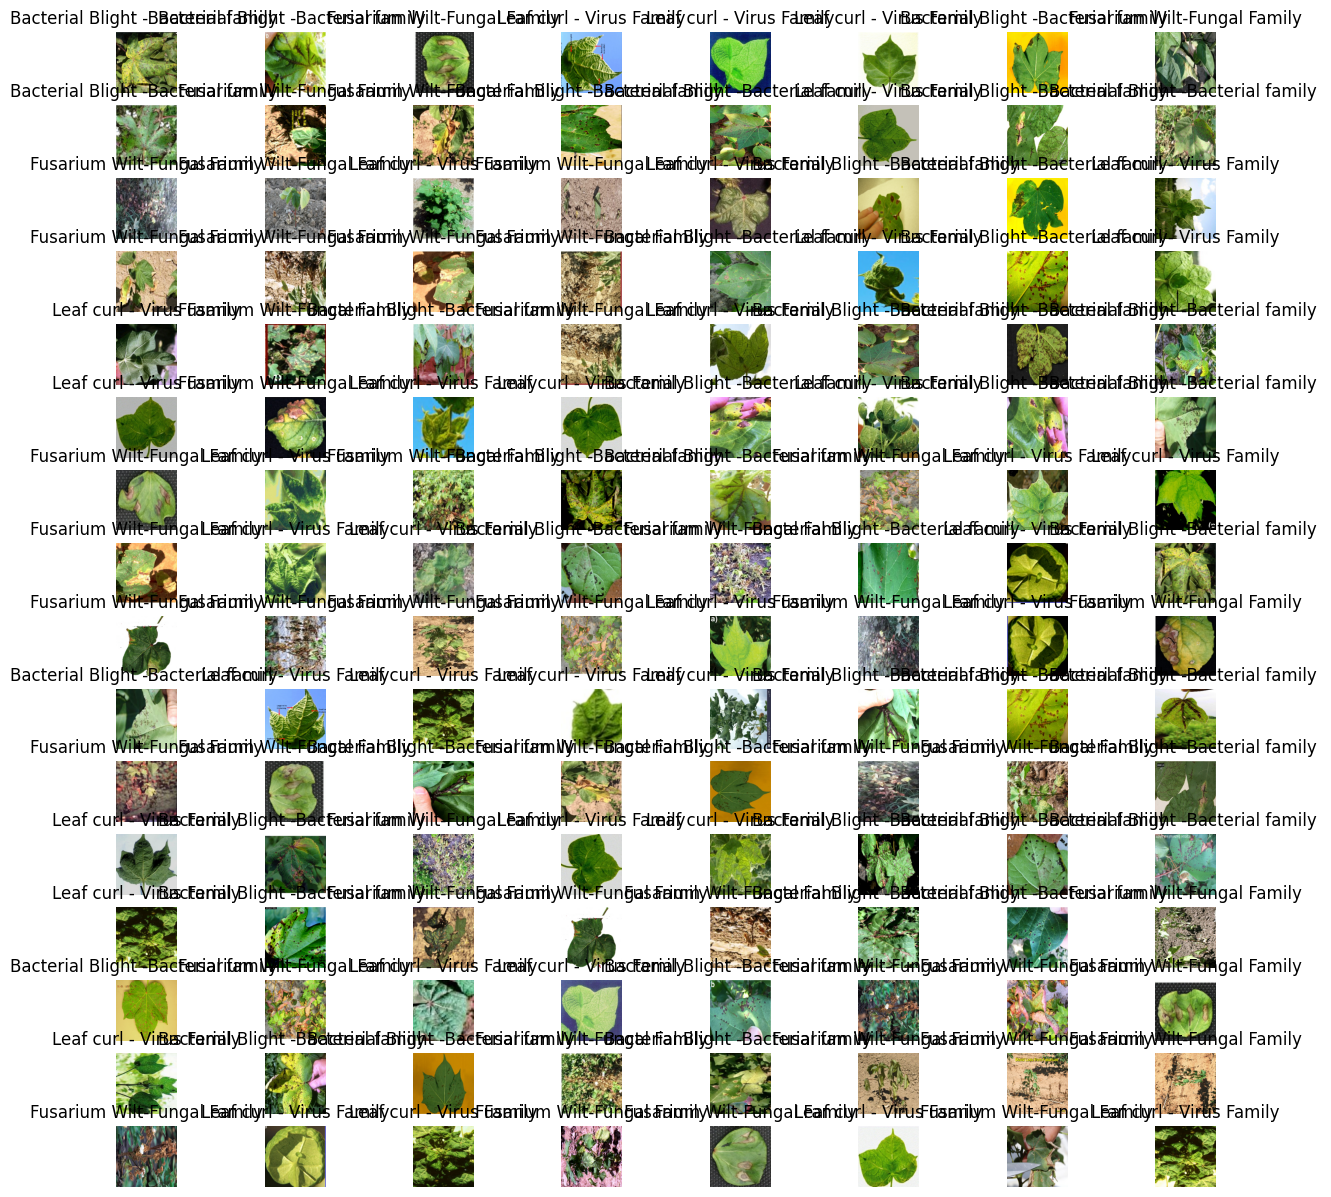

In [ ]:
BUFFER_SIZE = len(train_set)
train_set = train_set.shuffle(BUFFER_SIZE)

# our desired image size
IMAGE_SIZE = 224
# read, turn image into number, normalize, resize
def preprocess_image(image_path, labels=None):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
  return image, labels
# apply
train_set = train_set.map(preprocess_image)
val_set = val_set.map(preprocess_image)


# batch size
BATCH_SIZE = 128
# batching train & validation set
train_set = train_set.batch(BATCH_SIZE)
val_set = val_set.batch(BATCH_SIZE)
# check element spec
train_set.element_spec

def show_images_in_a_batch(images, labels):
  plt.figure(figsize=(15, 15))
# for each image in one batch (32 images)
  for i in range(128):
# Create subplots (8 rows, 5 columns)
    ax = plt.subplot(16, 8, i+1) # i = index
# Show the image
    plt.imshow(images[i])
# Add the image label as the title
    plt.title(unique_label[np.argmax(labels[i])])
# Turn the grid lines off
    plt.axis("off")
# take one random batch from training set
sample_train_images, sample_train_labels = next(iter(train_set))
# show
show_images_in_a_batch(sample_train_images, sample_train_labels)

In [ ]:
# 1. Create Model
model = tf.keras.Sequential([
# transfer learning model
hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"),
# output layer
tf.keras.layers.Dense(units=num_unique_label, activation='softmax')    ])
# 2. Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# build the model and pass the input shape
model.build(input_shape = [None, 224, 224, 3])
# 3. Create Callback
# EARLYSTOPPING CALLBACK, monitor the val loss (prevent overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# 4. Training Model
history_train = model.fit(train_set, epochs=2, validation_data = val_set, callbacks=[early_stopping])

Epoch 1/2
10/10 [==============================] - 318s 30s/step - loss: 0.8274 - accuracy: 0.6324 - val_loss: 0.3954 - val_accuracy: 0.8837
Epoch 2/2
10/10 [==============================] - 297s 30s/step - loss: 0.3485 - accuracy: 0.8824 - val_loss: 0.2536 - val_accuracy: 0.9302


In [ ]:
model.save("ME_model.h5")
model_path="ME_model.h5"

Saving img1.jpg to img1.jpg
Saving img2.jpg to img2.jpg
Saving img3.jpeg to img3.jpeg
Saving img4.jpg to img4.jpg
Saving img6.jpg to img6.jpg
Saving img7.jpg to img7.jpg
Saving img8.jpg to img8.jpg
Saving img9.jpeg to img9 (1).jpeg
['/content/img1.jpg', '/content/img2.jpg', '/content/img3.jpeg', '/content/img4.jpg', '/content/img6.jpg', '/content/img7.jpg', '/content/img8.jpg', '/content/img9 (1).jpeg']
5/5 [==============================] - 34s 7s/step
[[1.74746990e-01 7.77537405e-01 4.77154665e-02]
 [6.19541912e-04 3.51022318e-04 9.99029338e-01]
 [2.75631305e-02 1.73464715e-01 7.98972130e-01]
 [3.57539207e-02 9.05851424e-01 5.83946481e-02]
 [1.84976850e-02 4.02412452e-02 9.41261053e-01]
 [1.60259916e-03 9.97518837e-01 8.78483988e-04]
 [3.88765931e-01 3.86413664e-01 2.24820346e-01]
 [9.51862752e-01 2.78502274e-02 2.02869605e-02]
 [7.78537095e-01 1.63333446e-01 5.81293926e-02]
 [2.81449687e-02 6.20632097e-02 9.09791827e-01]
 [9.07388985e-01 4.13647387e-03 8.84743556e-02]
 [3.71402665e-

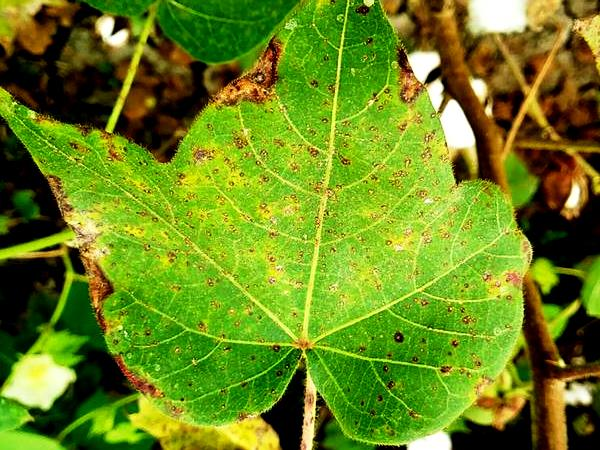

Fusarium Wilt-Fungal Family


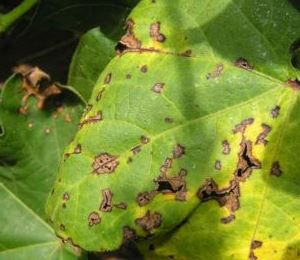

Fusarium Wilt-Fungal Family


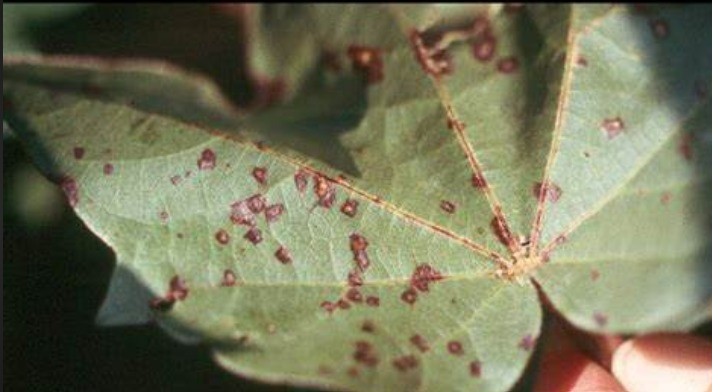

Leaf curl - Virus Family


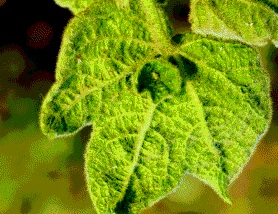

Fusarium Wilt-Fungal Family


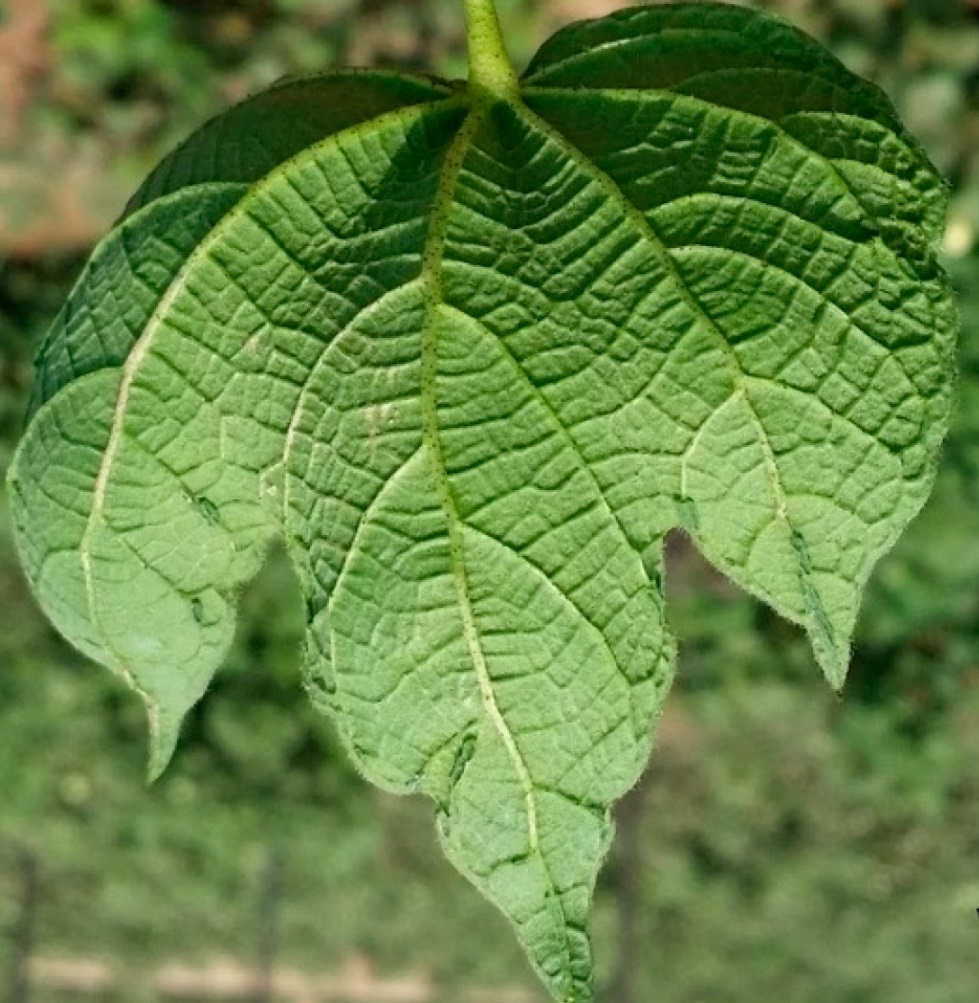

Leaf curl - Virus Family


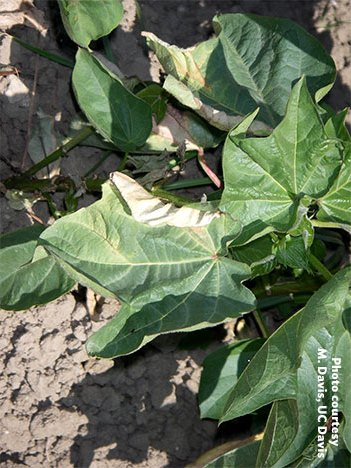

Bacterial Blight -Bacterial family 


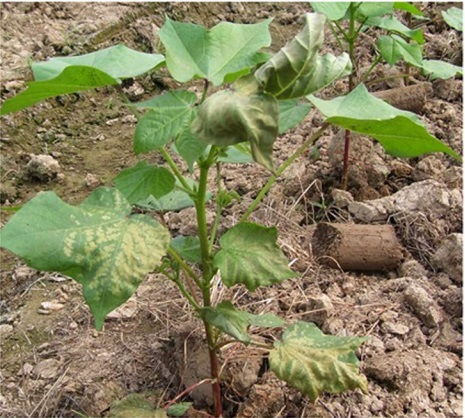

Bacterial Blight -Bacterial family 


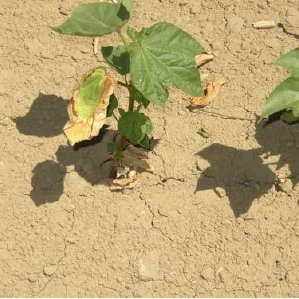

                                     precision    recall  f1-score   support

Bacterial Blight -Bacterial family        0.88      0.98      0.93        52
        Fusarium Wilt-Fungal Family       0.94      0.81      0.87        37
           Leaf curl - Virus Family       1.00      0.97      0.99        40

                           accuracy                           0.93       129
                          macro avg       0.94      0.92      0.93       129
                       weighted avg       0.93      0.93      0.93       129

[[51  1  0]
 [ 7 30  0]
 [ 0  1 39]]


AttributeError: ignored

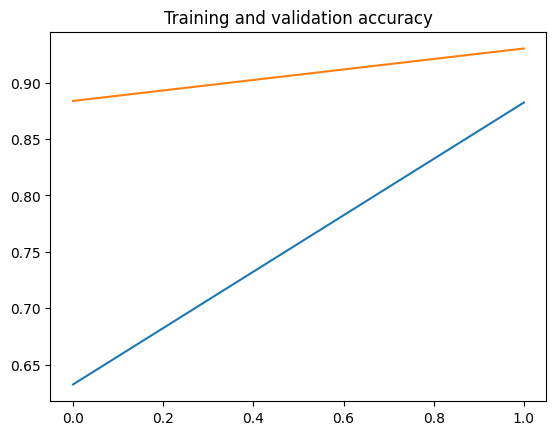

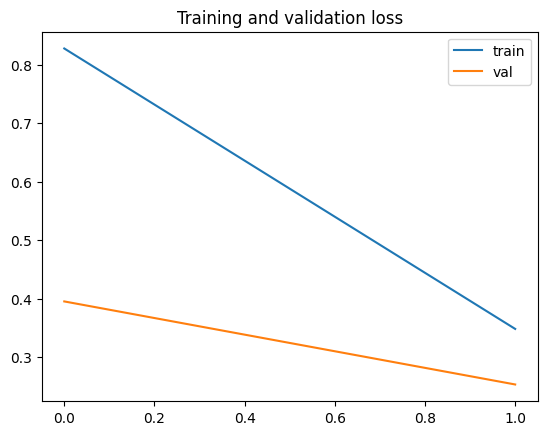

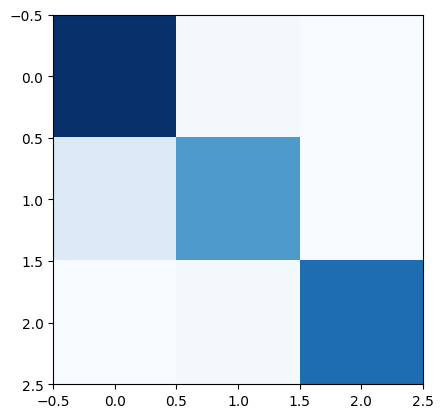

In [ ]:
# train
from sklearn.metrics import classification_report
acc = history_train.history['accuracy']
loss = history_train.history['loss']
# validation
val_acc = history_train.history['val_accuracy']
val_loss = history_train.history['val_loss']
# range number of epochs
epochs = range(len(acc))
# plot training and validation accuracy per epoch
plt.figure()
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()
# plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'])
# upload files
uploaded=files.upload()
filename = []
test_images = []
for fn in uploaded.keys():
    filename.append(fn)

    path='/content/' + fn
    test_images.append(path)
print(test_images)

# turn into set
test_set = tf.data.Dataset.from_tensor_slices(( tf.constant(list(X_val)) ))
# preprocess
test_set = test_set.map(preprocess_image)
# batching
test_set = test_set.batch(batch_size=32)


# predict
test_predictions = model.predict(test_set)
print(test_predictions)
label_prediction = []
for i in range(len(test_predictions)):
    label_prediction.append(unique_label[np.argmax(test_predictions[i])])
print(label_prediction)
print(list(y_val))
unique_labels = np.unique(Test_label)
num_classes = len(unique_labels)
# show prediction results
for i in range(len(test_images)):
    print(label_prediction[i])
    pil_img = Image(filename=test_images[i], width=150, height=150)
    display(pil_img)
cm = confusion_matrix(list(y_val),label_prediction)
cr=classification_report(list(y_val),label_prediction)
print(cr)

print(cm)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.imshow(cr, cmap=plt.cr.Blues)
plt.title('Confusion Matrix for Cotton Disease Classification')
plt.colorbar()
tick_marks = np.arange(len(unique_label))
plt.xticks(tick_marks, unique_label, rotation=45)
plt.yticks(tick_marks, unique_label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')